# K-prototype Cluster Algorithm

- https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb 

---

## Import module

In [1]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine

# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [3]:
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Import data

Data source: http://eforexcel.com/wp/downloads-18-sample-csv-files-data-sets-for-testing-sales/

In [4]:
df = pd.read_csv('data/10000 Sales Records.csv')

In [5]:
print('Dimension data: {} rows and {} columns'.format(len(df), len(df.columns)))
df.head()

Dimension data: 10000 rows and 14 columns


,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Chad,Office Supplies,Online,L,1/27/2011,292494523,2/12/2011,4484,651.210,524.960,2920025.640,2353920.640,566105.000
1,Europe,Latvia,Beverages,Online,C,12/28/2015,361825549,1/23/2016,1075,47.450,31.790,51008.750,34174.250,16834.500
2,Middle East and North Africa,Pakistan,Vegetables,Offline,C,1/13/2011,141515767,2/1/2011,6515,154.060,90.930,1003700.900,592408.950,411291.950
3,Sub-Saharan Africa,Democratic Republic of the Congo,Household,Online,C,9/11/2012,500364005,10/6/2012,7683,668.270,502.540,5134318.410,3861014.820,1273303.590
4,Europe,Czech Republic,Beverages,Online,C,10/27/2015,127481591,12/5/2015,3491,47.450,31.790,165647.950,110978.890,54669.060


In [6]:
df.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          10000 non-null  object 
 1   Country         10000 non-null  object 
 2   Item Type       10000 non-null  object 
 3   Sales Channel   10000 non-null  object 
 4   Order Priority  10000 non-null  object 
 5   Order Date      10000 non-null  object 
 6   Order ID        10000 non-null  int64  
 7   Ship Date       10000 non-null  object 
 8   Units Sold      10000 non-null  int64  
 9   Unit Price      10000 non-null  float64
 10  Unit Cost       10000 non-null  float64
 11  Total Revenue   10000 non-null  float64
 12  Total Cost      10000 non-null  float64
 13  Total Profit    10000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 1.1+ MB


In [8]:
df.select_dtypes('object').nunique()

Region               7
Country            185
Item Type           12
Sales Channel        2
Order Priority       4
Order Date        2691
Ship Date         2719
dtype: int64

In [9]:
# Summary statistics of numerical variable
for i in df.select_dtypes('object').columns:
    print(df[i].value_counts(),'\n')

Europe                               2633
Sub-Saharan Africa                   2603
Asia                                 1469
Middle East and North Africa         1264
Central America and the Caribbean    1019
Australia and Oceania                 797
North America                         215
Name: Region, dtype: int64 

United Kingdom    72
Lithuania         72
Moldova           71
Croatia           70
Seychelles        70
                  ..
Slovakia          42
Greenland         41
Tajikistan        40
Saint Lucia       39
Mali              35
Name: Country, Length: 185, dtype: int64 

Personal Care      888
Household          875
Clothes            872
Baby Food          842
Office Supplies    837
Vegetables         836
Cosmetics          834
Cereal             825
Snacks             816
Meat               798
Fruits             795
Beverages          782
Name: Item Type, dtype: int64 

Online     5061
Offline    4939
Name: Sales Channel, dtype: int64 

C    2555
H    2503
L    24

In [10]:
df.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,549871874.366,5002.856,268.143,188.807,1333355.131,938265.784,395089.347
std,260783511.133,2873.246,217.944,176.446,1465026.174,1145914.069,377554.961
min,100089156.000,2.000,9.330,6.920,167.940,124.560,43.380
25%,321806669.000,2530.750,109.280,56.670,288551.078,164785.530,98329.140
50%,548566305.000,4962.000,205.700,117.110,800051.210,481605.840,289099.020
75%,775998103.500,7472.000,437.200,364.690,1819143.390,1183821.520,566422.708
max,999934232.000,10000.000,668.270,524.960,6680026.920,5241725.600,1738178.390


In [11]:
# Check missing value
df.isna().sum()

Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Unit Price        0
Unit Cost         0
Total Revenue     0
Total Cost        0
Total Profit      0
dtype: int64

## Explanatory data analysis

#### Distribution of region

In [12]:
df_region = pd.DataFrame(df['Region'].value_counts()).reset_index()
df_region['Percentage'] = df_region['Region'] / df['Region'].value_counts().sum()
df_region.rename(columns = {'index':'Region', 'Region':'Total'}, inplace = True)
df_region = df_region.sort_values('Total', ascending = True).reset_index(drop = True)
df_region

,Region,Total,Percentage
0,North America,215,0.021
1,Australia and Oceania,797,0.080
2,Central America and the Caribbean,1019,0.102
3,Middle East and North Africa,1264,0.126
4,Asia,1469,0.147
5,Sub-Saharan Africa,2603,0.260
6,Europe,2633,0.263


In [13]:
df_region = df.groupby('Region').agg({
    'Region': 'count',
    'Units Sold': 'mean',
    'Total Revenue': 'mean',
    'Total Cost': 'mean',
    'Total Profit': 'mean'
    }
).rename(columns = {'Region': 'Total'}).reset_index().sort_values('Total', ascending = True)

In [14]:
df_region

,Region,Total,Units Sold,Total Revenue,Total Cost,Total Profit
5,North America,215,5373.358,1559778.805,1097008.967,462769.838
1,Australia and Oceania,797,4986.769,1317192.267,910578.451,406613.816
2,Central America and the Caribbean,1019,5081.063,1369509.041,973672.093,395836.948
4,Middle East and North Africa,1264,5116.219,1357304.982,953884.180,403420.803
0,Asia,1469,5015.488,1365082.080,965215.983,399866.097
6,Sub-Saharan Africa,2603,4967.808,1287190.079,903155.468,384034.611
3,Europe,2633,4920.385,1322207.396,932158.169,390049.226


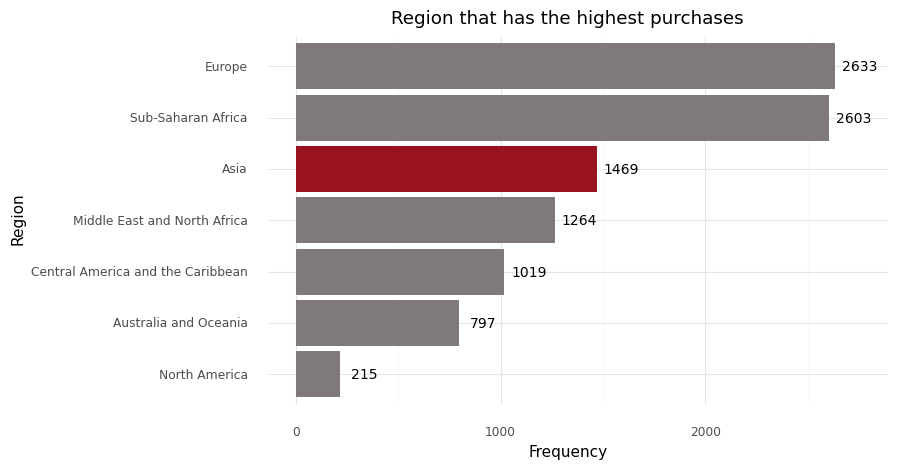

<ggplot: (165534255171)>

In [15]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_region)+
    geom_bar(aes(x = 'Region',
                 y = 'Total'),
             fill = np.where(df_region['Region'] == 'Asia', '#981220', '#80797c'),
             stat = 'identity')+
    geom_text(aes(x = 'Region',
                   y = 'Total',
                   label = 'Total'),
               size = 10,
               nudge_y = 120)+
    labs(title = 'Region that has the highest purchases')+
    xlab('Region')+
    ylab('Frequency')+
    scale_x_discrete(limits = df_region['Region'].tolist())+
    theme_minimal()+
    coord_flip()
)

#### Distribution of item type

In [16]:
# Order the index of cross tabulation
order_region = df_region['Region'].to_list()
order_region.append('All')
order_region

['North America',
 'Australia and Oceania',
 'Central America and the Caribbean',
 'Middle East and North Africa',
 'Asia',
 'Sub-Saharan Africa',
 'Europe',
 'All']

In [17]:
df_item = pd.crosstab(df['Region'], df['Item Type'], margins = True).reindex(order_region, axis = 0).reset_index()
# Remove index name
df_item.columns.name = None
df_item

,Region,Baby Food,Beverages,Cereal,Clothes,Cosmetics,Fruits,Household,Meat,Office Supplies,Personal Care,Snacks,Vegetables,All
0,North America,21,20,16,21,20,15,20,17,20,17,16,12,215
1,Australia and Oceania,65,50,69,77,75,55,78,61,50,76,72,69,797
2,Central America and the Caribbean,74,92,77,84,77,81,104,75,94,82,89,90,1019
3,Middle East and North Africa,105,96,104,111,99,104,128,101,103,112,95,106,1264
4,Asia,132,108,121,116,125,111,116,114,132,137,120,137,1469
5,Sub-Saharan Africa,235,220,211,229,203,230,218,207,207,223,221,199,2603
6,Europe,210,196,227,234,235,199,211,223,231,241,203,223,2633
7,All,842,782,825,872,834,795,875,798,837,888,816,836,10000


## Data pre-processing

#### Remove unused columns for the next analysis `Country`, `Order Date`, `Order ID`, and `Ship Date`

In [18]:
df.drop(['Country', 'Order Date', 'Order ID', 'Ship Date'], axis = 1, inplace = True)

In [19]:
print('Dimension data: {} rows and {} columns'.format(len(df), len(df.columns)))
df.head()

Dimension data: 10000 rows and 10 columns


,Region,Item Type,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Office Supplies,Online,L,4484,651.210,524.960,2920025.640,2353920.640,566105.000
1,Europe,Beverages,Online,C,1075,47.450,31.790,51008.750,34174.250,16834.500
2,Middle East and North Africa,Vegetables,Offline,C,6515,154.060,90.930,1003700.900,592408.950,411291.950
3,Sub-Saharan Africa,Household,Online,C,7683,668.270,502.540,5134318.410,3861014.820,1273303.590
4,Europe,Beverages,Online,C,3491,47.450,31.790,165647.950,110978.890,54669.060


## Cluster analysis

Thanks to https://github.com/aryancodify/Clustering

In [20]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Region', 'Item Type', 'Sales Channel', 'Order Priority']
Categorical columns position  : [0, 1, 2, 3]


In [21]:
dfMatrix = df.to_numpy()

In [22]:
dfMatrix

array([['Sub-Saharan Africa', 'Office Supplies', 'Online', ...,
        2920025.64, 2353920.64, 566105.0],
       ['Europe', 'Beverages', 'Online', ..., 51008.75, 34174.25,
        16834.5],
       ['Middle East and North Africa', 'Vegetables', 'Offline', ...,
        1003700.9, 592408.95, 411291.95],
       ...,
       ['Sub-Saharan Africa', 'Vegetables', 'Offline', ..., 388847.44,
        229507.32, 159340.12],
       ['Sub-Saharan Africa', 'Meat', 'Online', ..., 3672974.34,
        3174991.14, 497983.2],
       ['Asia', 'Snacks', 'Offline', ..., 55081.38, 35175.84, 19905.54]],
      dtype=object)

Error of initialization: https://github.com/nicodv/kmodes/blob/master/README.rst#faq

In [23]:
# Choosing optimal K
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


In [24]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
df_cost.head()

,Cluster,Cost
0,1,36016179764884296.000
1,2,9627992230178396.000
2,3,4960713581025175.000
3,4,2927463064172953.000
4,5,1975348817799526.000


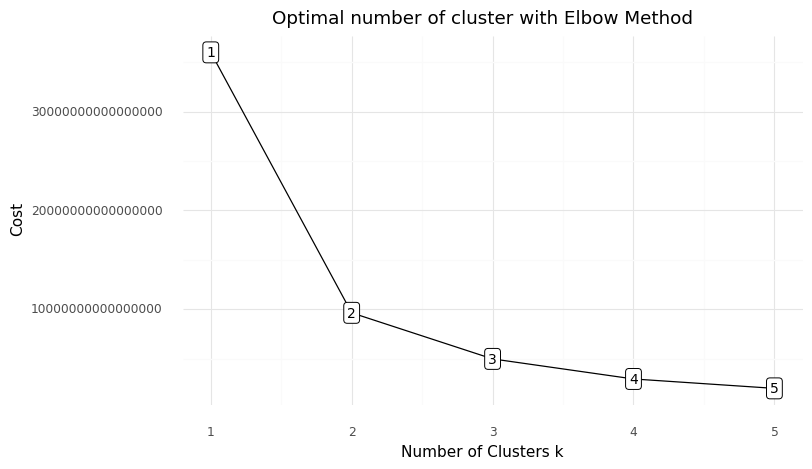

<ggplot: (165534246675)>

In [25]:
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [26]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([2, 1, 1, ..., 1, 0, 1], dtype=uint16)

In [27]:
# Cluster centorid
kprototype.cluster_centroids_

[array([[7.90436555e+03, 5.93526513e+02, 4.57785496e+02, 4.62276055e+06,
         3.55912112e+06, 1.06363942e+06],
        [4.04666949e+03, 1.63259107e+02, 1.05796869e+02, 4.67709452e+05,
         2.81142955e+05, 1.86566497e+05],
        [6.09327542e+03, 3.84264504e+02, 2.75097501e+02, 1.99588812e+06,
         1.38053953e+06, 6.15348596e+05]]),
 array([['Europe', 'Household', 'Offline', 'L'],
        ['Sub-Saharan Africa', 'Personal Care', 'Online', 'C'],
        ['Europe', 'Cosmetics', 'Online', 'H']], dtype='<U18')]

In [28]:
# Check the iteration of the clusters created
kprototype.n_iter_

7

In [29]:
# Check the cost of the clusters created
kprototype.cost_

4960713581025175.0

In [30]:
# Add the cluster to the dataframe
df['cluster_id'] = kprototype.labels_ 

In [31]:
df_region = pd.DataFrame(df['Region'].value_counts()).reset_index()
df_region['Percentage'] = df_region['Region'] / df['Region'].value_counts().sum()
df_region.rename(columns = {'index':'Region', 'Region':'Total'}, inplace = True)
df_region = df_region.sort_values('Total', ascending = True).reset_index(drop = True)
df_region

,Region,Total,Percentage
0,North America,215,0.021
1,Australia and Oceania,797,0.080
2,Central America and the Caribbean,1019,0.102
3,Middle East and North Africa,1264,0.126
4,Asia,1469,0.147
5,Sub-Saharan Africa,2603,0.260
6,Europe,2633,0.263
